### in this script, we calculate basic similarity and distance between indivuals phee calls, based on dynamic time warping of thier spectrograms, mfcc, and traditonal acoustic paramters

In [2]:
# ─── Paths & folders (same pattern as previous scripts) ───────────────────────
from pathlib import Path

BASE_DIR            = Path.cwd().parent            # notebook lives in …/2025/code/
SPECTRAL_DATA_DIR    = BASE_DIR / "spectral data"
DIST_MAT_DIR         = BASE_DIR / "distance_matrices"
FIGURES_DIR          = BASE_DIR / "figures"
EXTRACT_DIR          = BASE_DIR / "extracted calls"   # already created

for p in (DIST_MAT_DIR, FIGURES_DIR):
    p.mkdir(exist_ok=True)

print("✔ Paths ready")


✔ Paths ready


we first plot a few example spectrogrmans and look at thier aligment scores to each other as a satnity check, as paramters are to be refined for spectrogram production and DTW is a relatively new method so should be tested

Visualising 10 random calls …


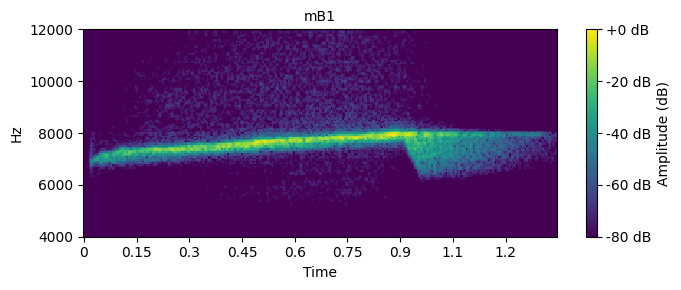

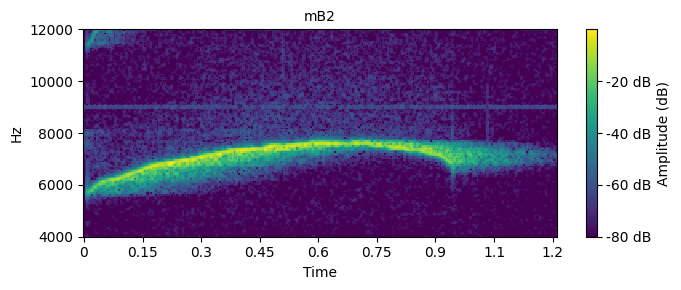

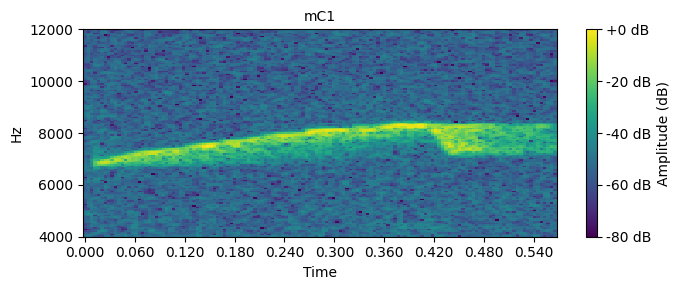

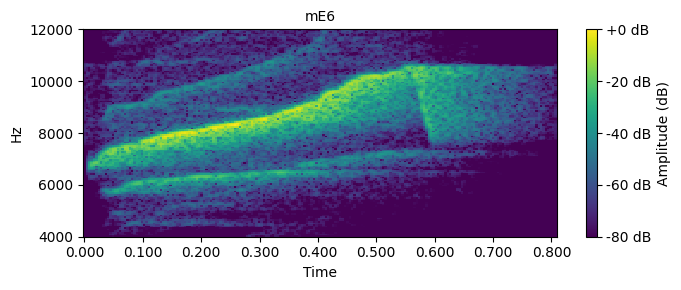

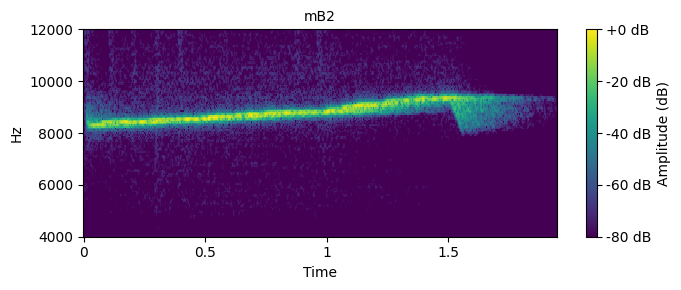

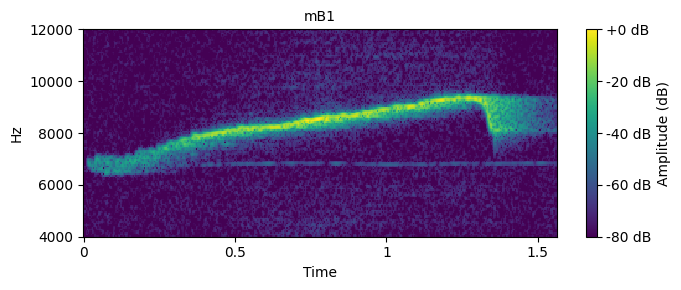

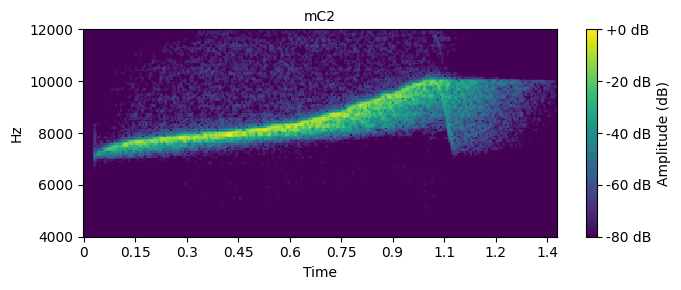

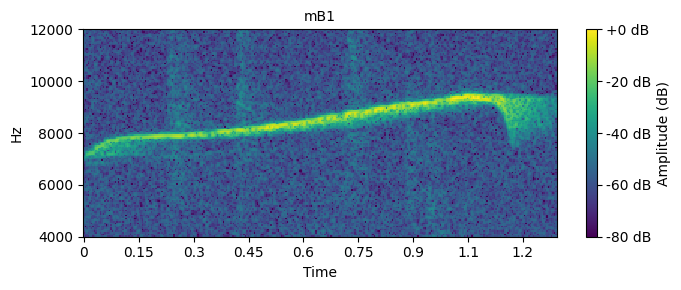

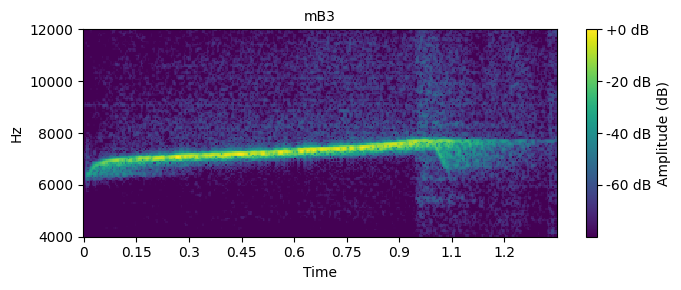

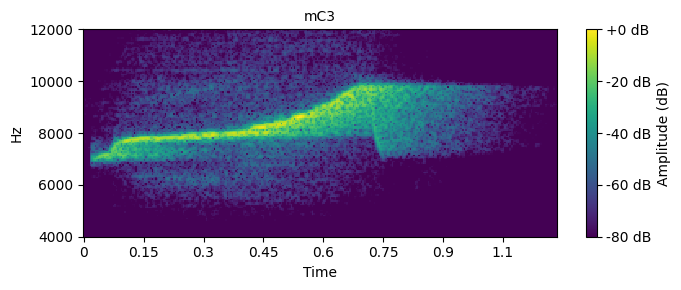

Computing alignment costs: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Alignment-cost matrix ready (shape: (10, 10) )
[[0.         0.00648387 0.00792359 0.01762133 0.01507478 0.00876164
  0.00897148 0.01030331 0.00366508 0.00973604]
 [0.00648387 0.         0.01269036 0.018075   0.01738855 0.01241018
  0.01557958 0.0155319  0.00494241 0.0141084 ]
 [0.00792359 0.01269036 0.         0.02355869 0.0182139  0.01557074
  0.01575844 0.01854612 0.00954018 0.01488805]
 [0.01762133 0.018075   0.02355869 0.         0.01367924 0.01268767
  0.01008189 0.01664712 0.0151718  0.00833571]
 [0.01507478 0.01738855 0.0182139  0.01367924 0.         0.00413868
  0.0078469  0.00563714 0.01446501 0.01079692]
 [0.00876164 0.01241018 0.01557074 0.01268767 0.00413868 0.
  0.00507932 0.00460258 0.00912925 0.00785702]
 [0.00897148 0.01557958 0.01575844 0.01008189 0.0078469  0.00507932
  0.         0.00747017 0.01065274 0.00373265]
 [0.01030331 0.0155319  0.01854612 0.01664712 0.00563714 0.00460258
  0.00747017 0.         0.01213613 0.01020644]
 [0.00366508 0.00494241 0.00954018 0.015

In [22]:
# %% ------------------------------------------------------------
#  Alignment-cost distance (DTW, 4–12 kHz band) – trial run
# ---------------------------------------------------------------
import os, random, pathlib, librosa, numpy as np, pandas as pd, matplotlib.pyplot as plt
import librosa.display
from pydub import AudioSegment
from fastdtw import fastdtw
from scipy.spatial.distance import cosine
from tqdm import tqdm

# --- LOAD processed call table (path now relative) ---------------------------
CSV_PATH = SPECTRAL_DATA_DIR / "Processed_spec_data.csv"
df_clean = pd.read_csv(CSV_PATH)
df       = df_clean.copy()

# -----------------------------------------------------------------
#  Helper 1: build a spectrogram with optional symmetric zero-padding
# -----------------------------------------------------------------
def generate_spectrogram(audio_file_path, pad_duration=0):
    """
    audio_file_path : str or Path – single-call wav
    pad_duration    : float      – seconds to pad on both sides (total)
    returns         : S_db (dB-scaled spectrogram), sr
    """
    audio = AudioSegment.from_wav(str(audio_file_path))
    y = np.array(audio.get_array_of_samples(), dtype=np.float32)
    sr = audio.frame_rate

    # convert stereo to mono
    if audio.channels == 2:
        y = y.reshape((-1, 2)).mean(axis=1)

    # pad if requested
    target_len = int(pad_duration * sr)
    if len(y) < target_len:
        pad = target_len - len(y)
        y = np.pad(y, (pad // 2, pad - pad // 2), mode="constant")

    # STFT → dB
    N_FFT      = 2048       #  ~22 ms @ 48 kHz
    HOP        = N_FFT // 4  #  25 % overlap
    WIN_LENGTH = N_FFT 
    D = librosa.stft(
        y,
        n_fft=N_FFT,
        hop_length=HOP,
        win_length=WIN_LENGTH,
        window="hann",
    )
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db, sr

# -----------------------------------------------------------------
#  Helper 2: plot nicely with librosa.display
# -----------------------------------------------------------------
def show_spectrogram(S_db, sr, title):
    plt.figure(figsize=(7, 3))
    librosa.display.specshow(
        S_db,
        sr=sr,
        hop_length=512,
        x_axis="time",
        y_axis="linear",
        cmap="viridis",
    )

    plt.ylim(4_000, 12_000)
    
    plt.colorbar(format="%+2.0f dB", label="Amplitude (dB)")
    plt.title(title, fontsize=10)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------
#  Pick 20 random calls that actually have an extracted wav
# -----------------------------------------------------------------
valid_rows = df[df["call_audio_path"].notna()].copy()
sample_df  = valid_rows.sample(n=10, random_state=42)

print(f"Visualising {len(sample_df)} random calls …")

for _, row in sample_df.iterrows():
    wav_path = pathlib.Path(row["call_audio_path"])
    if not wav_path.exists():
        print("⚠️  Missing file:", wav_path)
        continue

    # optional: shorter title (call label only)
    _, label_part = row["filename"].rsplit("_labelled_", 1)
    call_label = label_part.replace(".wav", "")
    
    S_db, sr = generate_spectrogram(wav_path, pad_duration=0.5)
    show_spectrogram(S_db, sr, title=call_label)
# --- helper: alignment cost exactly like your snippet -----------
def compute_alignment_cost(S1, S2):
    """
    S1, S2 : 2-D spectrograms (freq_bins × time_frames)
    distance = fastdtw on frame-vectors (cosine), normalised by len(S1)+len(S2)
    """
    dist, _ = fastdtw(S1.T, S2.T, dist=cosine)
    return dist / (S1.shape[1] + S2.shape[1])

# --- helper: keep only 4–12 kHz rows ---------------------------
def crop_band(S_db, sr, lo=4_000, hi=12_000, n_fft=2048):
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    mask  = (freqs >= lo) & (freqs <= hi)
    return S_db[mask, :]

# ------------------------------------------------------------
# 1)  Build spectrogram list for every row in sample_df
# ------------------------------------------------------------
spectrograms = []
labels       = []

for _, row in tqdm(sample_df.iterrows(),
                   total=len(sample_df),
                   desc="Generating spectrograms"):
    wav_path = pathlib.Path(row["call_audio_path"])
    S_db, sr = generate_spectrogram(wav_path, pad_duration=0)
    S_band   = crop_band(S_db, sr)          # 4–12 kHz
    spectrograms.append(S_band)
    
    _, lbl_part = row["filename"].rsplit("_labelled_", 1)
    labels.append(lbl_part.replace(".wav", ""))

# ------------------------------------------------------------
# 2)  Pair-wise alignment-cost matrix
# ------------------------------------------------------------
n = len(spectrograms)
dist_mat = np.zeros((n, n), dtype=float)

for i in tqdm(range(n), desc="Computing alignment costs"):
    for j in range(i + 1, n):
        cost = compute_alignment_cost(spectrograms[i], spectrograms[j])
        dist_mat[i, j] = dist_mat[j, i] = cost

print("\nAlignment-cost matrix ready (shape:", dist_mat.shape, ")")
print(dist_mat)


we calculate the distance matrix between indivual calls using all 3 metrics 

In [1]:
# %% ------------------------------------------------------------
#  Build & save distance matrices (DTW 4–12 kHz • trad-PCA • mfcc-PCA)
# ---------------------------------------------------------------
from pathlib import Path
import os, numpy as np, pandas as pd, librosa, soundfile as sf
from pydub import AudioSegment
from fastdtw import fastdtw
from scipy.spatial.distance import cosine, pdist, squareform
from tqdm.auto import tqdm

# ------------------------------------------------------------
# 0)  Paths & data load
# ------------------------------------------------------------
BASE_DIR            = Path.cwd().parent              # notebook in …/2025/code/
SPECTRAL_DATA_DIR   = BASE_DIR / "spectral data"
DIST_MAT_DIR        = BASE_DIR / "distance_matrices"
DIST_MAT_DIR.mkdir(exist_ok=True)

CSV_PATH    = SPECTRAL_DATA_DIR / "Processed_spec_data.csv"
df_clean    = pd.read_csv(CSV_PATH)

# keep only calls that have an extracted wav
df_pool = df_clean[df_clean["call_audio_path"].notna()].reset_index(drop=True)

# ------------------------------------------------------------
# Helper A  – spectrogram (optional symmetric pad)
# ------------------------------------------------------------
def generate_spectrogram(audio_file_path, pad_duration=0):
    """
    Returns a dB-scaled STFT spectrogram and the sample rate.
    pad_duration : seconds of total zero-padding to centre the call (default 0.5 s)
    """
    audio = AudioSegment.from_wav(str(audio_file_path))
    y  = np.array(audio.get_array_of_samples(), dtype=np.float32)
    sr = audio.frame_rate

    # stereo → mono
    if audio.channels == 2:
        y = y.reshape((-1, 2)).mean(axis=1)

    # symmetric pad if the call is shorter than pad_duration
    target_len = int(pad_duration * sr)
    if len(y) < target_len:
        pad = target_len - len(y)
        y   = np.pad(y, (pad // 2, pad - pad // 2), mode="constant")

    N_FFT, HOP, WIN = 2048, 512, 2048
    D    = librosa.stft(y, n_fft=N_FFT, hop_length=HOP,
                        win_length=WIN, window="hann")
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db, sr

# ------------------------------------------------------------
# Helper B  – crop 4–12 kHz band
# ------------------------------------------------------------
def crop_band(S_db, sr, lo=4_000, hi=12_000, n_fft=2048):
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    return S_db[(freqs >= lo) & (freqs <= hi), :]

# ------------------------------------------------------------
# Helper C  – alignment cost (FastDTW + cosine)
# ------------------------------------------------------------
def compute_alignment_cost(S1, S2):
    dist, _ = fastdtw(S1.T, S2.T, dist=cosine)
    # normalise by total number of time-frames
    return dist / (S1.shape[1] + S2.shape[1])

# ------------------------------------------------------------
# Main function  – compute & save distance matrices
# ------------------------------------------------------------
def compute_distance_matrices(sample_size=None):
    """
    Parameters
    ----------
    sample_size : None or int
        • None → use the full dataset (all calls with audio)
        • int  → random subset of that many calls

    Saves
    -----
    distance_matrices/
        dtw_dist_matrix_{N}calls.npy
        trad_pca_dist_matrix_{N}calls.npy
        mfcc_pca_dist_matrix_{N}calls.npy
        labels_{N}calls.csv          # subset metadata

    Returns
    -------
    subset_df : pandas.DataFrame
        The DataFrame of calls used for the matrices.
    """
    # ------------ 1. subset selection ---------------------------------------
    if sample_size is not None and sample_size < len(df_pool):
        subset_df = df_pool.sample(sample_size, random_state=42).reset_index(drop=True)
    else:
        subset_df = df_pool.copy()
        sample_size = len(subset_df)

    print(f"\n▶ Computing distance matrices for {sample_size} calls")

    # ------------ 2. DTW distance matrix ------------------------------------
    specs = []
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df),
                       desc="Generating spectrograms"):
        S_db, sr = generate_spectrogram(Path(row["call_audio_path"]), pad_duration=0)
        specs.append(crop_band(S_db, sr))    # keep 4–12 kHz band

    n = len(specs)
    dtw_mat = np.zeros((n, n), dtype=float)
    for i in tqdm(range(n), desc="FastDTW costs"):
        for j in range(i + 1, n):
            dtw_mat[i, j] = dtw_mat[j, i] = compute_alignment_cost(specs[i], specs[j])

    # ------------ 3. PCA Euclidean matrices ---------------------------------
    trad_cols = [f"trad_PC{i}" for i in range(1, 6)]
    mfcc_cols = [f"mfcc_PC{i}" for i in range(1, 6)]

    trad_mat = squareform(pdist(subset_df[trad_cols], metric="euclidean"))
    mfcc_mat = squareform(pdist(subset_df[mfcc_cols], metric="euclidean"))

    # ------------ 4. Save to disk -------------------------------------------
    tag = f"{sample_size}calls"
    np.save(DIST_MAT_DIR / f"dtw_dist_matrix_{tag}.npy",   dtw_mat)
    np.save(DIST_MAT_DIR / f"trad_pca_dist_matrix_{tag}.npy", trad_mat)
    np.save(DIST_MAT_DIR / f"mfcc_pca_dist_matrix_{tag}.npy", mfcc_mat)
    subset_df.to_csv(DIST_MAT_DIR / f"labels_{tag}.csv", index=False)

    print("✓ Saved DTW, trad-PCA, mfcc-PCA matrices and labels to", DIST_MAT_DIR)
    return subset_df


# ------------------------------------------------------------
subset_df = compute_distance_matrices(2200)   # 1 000-call subset
#subset_df = compute_distance_matrices()       # full dataset


C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)



▶ Computing distance matrices for 2200 calls


Generating spectrograms:   0%|          | 0/2200 [00:00<?, ?it/s]

FastDTW costs:   0%|          | 0/2200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
# %% ------------------------------------------------------------
#  Distance matrices via joblib (robust on Windows)
# ---------------------------------------------------------------
from pathlib import Path
import os, numpy as np, pandas as pd, librosa, joblib
from pydub import AudioSegment
from fastdtw import fastdtw
from scipy.spatial.distance import cosine, pdist, squareform
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from contextlib import contextmanager

# ─── 0.  Progress patch for joblib -----------------------------------------
@contextmanager
def tqdm_joblib(tqdm_obj):
    """Show tqdm progress for joblib.Parallel"""
    class Batch_cb(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_obj.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = Batch_cb
    try:
        yield tqdm_obj
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_obj.close()

# ─── 1.  Paths & data -------------------------------------------------------
BASE_DIR          = Path.cwd().parent
SPECTRAL_DATA_DIR = BASE_DIR / "spectral data"
DIST_MAT_DIR      = BASE_DIR / "distance_matrices"; DIST_MAT_DIR.mkdir(exist_ok=True)

df_pool = (pd.read_csv(SPECTRAL_DATA_DIR / "Processed_spec_data.csv")
           .query("call_audio_path.notna()")
           .reset_index(drop=True))

# ─── 2.  Helper functions ---------------------------------------------------
def load_spec_band(path):
    """single-call wav → 4–12 kHz STFT in dB (numpy array)"""
    audio = AudioSegment.from_wav(str(path))
    y  = np.array(audio.get_array_of_samples(), dtype=np.float32)
    sr = audio.frame_rate
    if audio.channels == 2:
        y = y.reshape((-1, 2)).mean(axis=1)
    D  = librosa.stft(y, n_fft=2048, hop_length=512,
                     win_length=2048, window="hann")
    S  = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)
    band  = S[(freqs >= 4_000) & (freqs <= 12_000), :]
    return band

def pair_cost(i, j, p_i, p_j):
    """worker: compute DTW alignment-cost for two wav paths"""
    S1 = load_spec_band(p_i)
    S2 = load_spec_band(p_j)
    dist, _ = fastdtw(S1.T, S2.T, dist=cosine)
    cost = dist / (S1.shape[1] + S2.shape[1])
    return i, j, cost

# ─── 3.  Main routine -------------------------------------------------------
def compute_distance_matrices(sample_size=None, n_jobs=-1):
    """n_jobs = -1 → all cores, 1 → serial, k → k workers"""
    subset = (df_pool.sample(sample_size, random_state=42).reset_index(drop=True)
              if sample_size and sample_size < len(df_pool)
              else df_pool.copy())
    N   = len(subset)
    tag = f"{N}calls"
    print(f"▶ {N} calls  |  DTW workers = {n_jobs if n_jobs!= -1 else os.cpu_count()}")

    # 3a. list of upper-triangular jobs (indices + wav paths)
    jobs = [(i, j,
             subset.loc[i, "call_audio_path"],
             subset.loc[j, "call_audio_path"])
            for i in range(N) for j in range(i+1, N)]
    total = len(jobs)

    dtw_mat = np.zeros((N, N), dtype=float)

    # 3b. parallel DTW with tqdm progress
    if n_jobs == 1:
        for i, j, p_i, p_j in tqdm(jobs, desc="DTW pairs"):
            _, _, c = pair_cost(i, j, p_i, p_j)
            dtw_mat[i, j] = dtw_mat[j, i] = c
    else:
        with tqdm_joblib(tqdm(total=total, desc="DTW pairs")):
            results = Parallel(n_jobs=n_jobs, backend="loky")(
                delayed(pair_cost)(i, j, p_i, p_j) for i, j, p_i, p_j in jobs)
        for i, j, c in results:
            dtw_mat[i, j] = dtw_mat[j, i] = c

    # 3c. PCA-Euclidean matrices
    trad_cols = [f"trad_PC{k}" for k in range(1,6)]
    mfcc_cols = [f"mfcc_PC{k}" for k in range(1,6)]
    trad_mat  = squareform(pdist(subset[trad_cols],  "euclidean"))
    mfcc_mat  = squareform(pdist(subset[mfcc_cols], "euclidean"))

    # 3d. save
    np.save(DIST_MAT_DIR / f"dtw_dist_matrix_{tag}.npy",   dtw_mat)
    np.save(DIST_MAT_DIR / f"trad_pca_dist_matrix_{tag}.npy", trad_mat)
    np.save(DIST_MAT_DIR / f"mfcc_pca_dist_matrix_{tag}.npy", mfcc_mat)
    subset.to_csv(DIST_MAT_DIR / f"labels_{tag}.csv", index=False)
    print("✓ saved →", DIST_MAT_DIR)
    return subset

# ─── 4.  Example run -------------------------------------------
if __name__ == "__main__":
    # 20-call demo on 4 cores:
    subset_df = compute_distance_matrices(sample_size=2200, n_jobs=4)
    # full dataset, all cores:
    #subset_df = compute_distance_matrices(n_jobs=-1)




▶ 2200 calls  |  DTW workers = 4


DTW pairs:   0%|          | 0/2418900 [00:00<?, ?it/s]

✓ saved → c:\Users\nakul\Desktop\marmoset project\2025_Work_Re-start_Marmoset\2025\distance_matrices


In [3]:
# %% ------------------------------------------------------------
#  Correlation between distance-matrix types  (upper-triangle only)
# ---------------------------------------------------------------
from scipy.stats import pearsonr
import numpy as np

tag = f"{len(subset_df)}calls"            # matches filenames just written

dtw_mat   = np.load(DIST_MAT_DIR / f"dtw_dist_matrix_{tag}.npy")
trad_mat  = np.load(DIST_MAT_DIR / f"trad_pca_dist_matrix_{tag}.npy")
mfcc_mat  = np.load(DIST_MAT_DIR / f"mfcc_pca_dist_matrix_{tag}.npy")

def upper_tri(mat):
    """Return the vectorised upper triangle (excluding diagonal)."""
    return mat[np.triu_indices_from(mat, k=1)]

dtw_flat  = upper_tri(dtw_mat)
trad_flat = upper_tri(trad_mat)
mfcc_flat = upper_tri(mfcc_mat)

pairs = {
    ("DTW", "Trad-PCA"): (dtw_flat, trad_flat),
    ("DTW", "MFCC-PCA"): (dtw_flat, mfcc_flat),
    ("Trad-PCA", "MFCC-PCA"): (trad_flat, mfcc_flat),
}

print("\n▶ Pearson correlations between distance matrices:")
for (name_a, name_b), (v1, v2) in pairs.items():
    r, p = pearsonr(v1, v2)
    print(f"  {name_a}  vs  {name_b}:  r = {r:.3f}   (p = {p:.3e})")



▶ Pearson correlations between distance matrices:
  DTW  vs  Trad-PCA:  r = 0.662   (p = 0.000e+00)
  DTW  vs  MFCC-PCA:  r = 0.656   (p = 0.000e+00)
  Trad-PCA  vs  MFCC-PCA:  r = 0.533   (p = 0.000e+00)


now we plot the UMAP projection of the indivual calls

same plot as before but with centroids added

C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

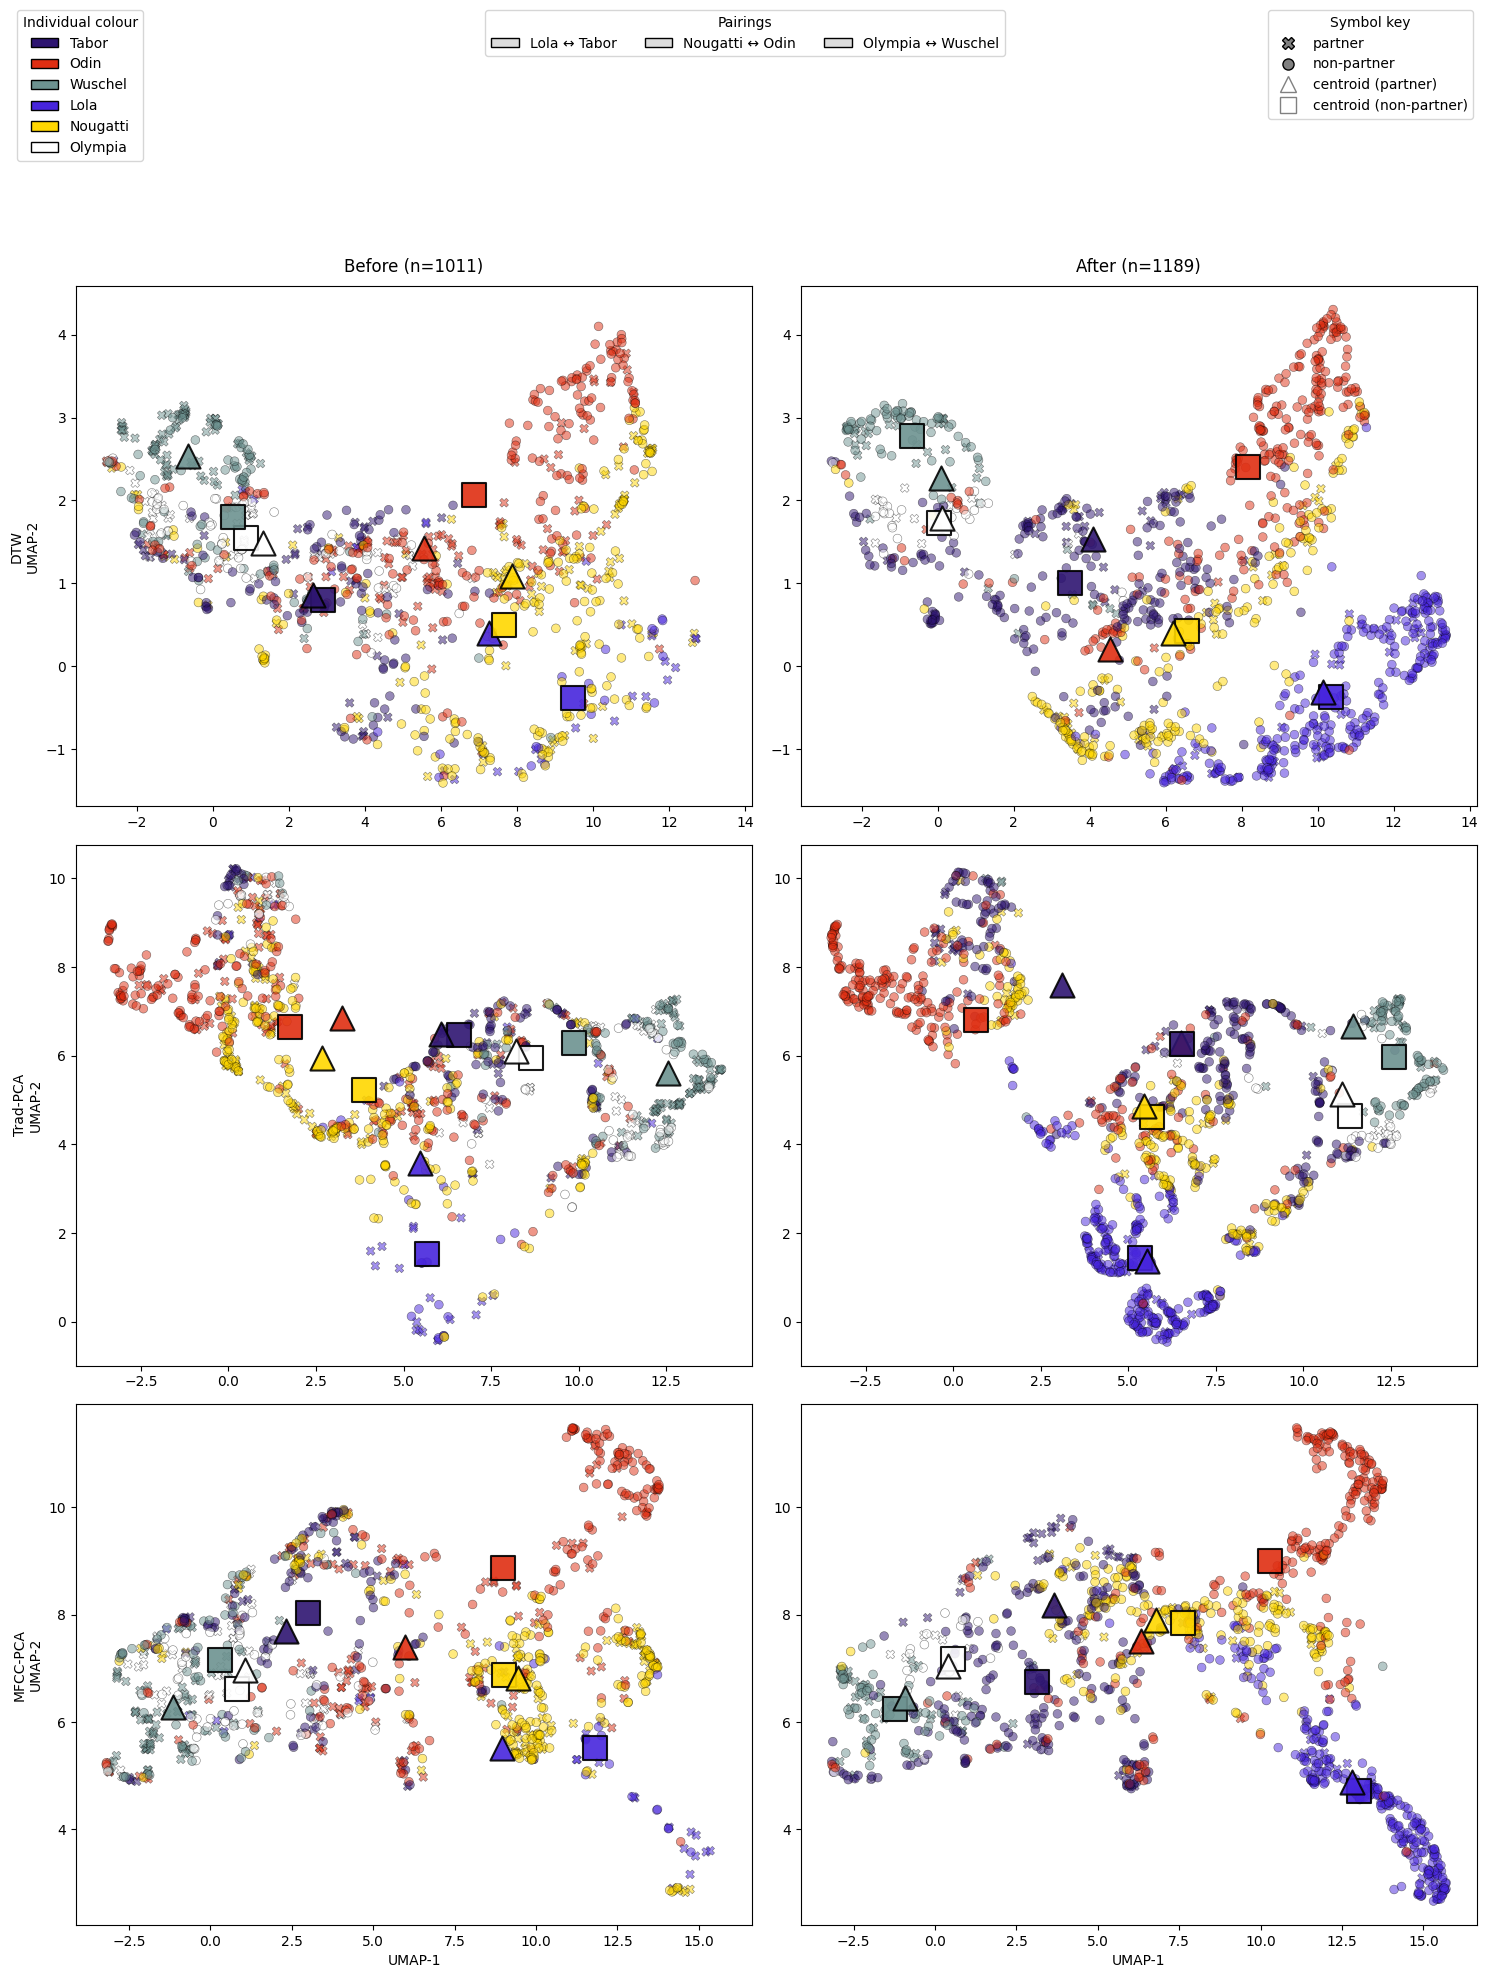

In [3]:
# %% ------------------------------------------------------------
#  UMAP grid (3 metrics × 2 stages)  +  transparent centroids
# ---------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, umap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ── 0.  Load matrices & metadata -------------------------------- #
TAG      = "2200calls"               # adjust if needed
DIST_DIR = BASE_DIR / "distance_matrices"

dtw_mat   = np.load(DIST_DIR / f"dtw_dist_matrix_{TAG}.npy")
trad_mat  = np.load(DIST_DIR / f"trad_pca_dist_matrix_{TAG}.npy")
mfcc_mat  = np.load(DIST_DIR / f"mfcc_pca_dist_matrix_{TAG}.npy")
sample_df = pd.read_csv(DIST_DIR / f"labels_{TAG}.csv")

# ── 1.  Partner / non-partner flag ------------------------------ #
pair_map = {"Tabor":"Lola", "Lola":"Tabor",
            "Odin":"Nougatti", "Nougatti":"Odin",
            "Wuschel":"Olympia", "Olympia":"Wuschel"}
sample_df["partner_status"] = sample_df.apply(
    lambda r: "partner" if pair_map.get(r["focal ID"]) == r["conspecific_ID"] else "non-partner",
    axis=1,
)

# ── 2.  UMAP embeddings ---------------------------------------- #
def umap_embed(mat):
    return umap.UMAP(metric="precomputed",
                     n_neighbors=30, min_dist=0.1,
                     random_state=2).fit_transform(mat)

embeddings = {
    "DTW":      umap_embed(dtw_mat),
    "Trad-PCA": umap_embed(trad_mat),
    "MFCC-PCA": umap_embed(mfcc_mat),
}
dfs = {m: sample_df.assign(UMAP1=e[:,0], UMAP2=e[:,1]) for m,e in embeddings.items()}

# ── 3.  Plot constants ----------------------------------------- #
PALETTE = {"Tabor":"#2e1571","Odin":"#df2e12","Wuschel":"#6D9290",
           "Lola":"#4725DD","Nougatti":"#ffd700","Olympia":"#ffffff"}

point_marker_map   = {"partner":"X", "non-partner":"o"}     # raw calls
centroid_marker_map = {"partner":"^", "non-partner":"s"}    # squares / diamonds

phases  = ["before","after"]
metrics = ["DTW","Trad-PCA","MFCC-PCA"]

# ── 4.  Draw 3×2 grid ------------------------------------------ #
fig, axs = plt.subplots(len(metrics), len(phases),
                        figsize=(15,20), sharex=False, sharey=False)

for r, metric in enumerate(metrics):
    row_xlim, row_ylim = [], []
    for c, phase in enumerate(phases):
        ax  = axs[r, c]
        sub = dfs[metric][dfs[metric]["stage"] == phase]

        # ---- plot individual calls ------------------------------
        for status, marker in point_marker_map.items():
            pts = sub[sub["partner_status"] == status]
            ax.scatter(pts["UMAP1"], pts["UMAP2"],
                       c=pts["focal ID"].map(PALETTE),
                       marker=marker, edgecolor='k', linewidth=0.4,
                       s=40, alpha=0.5,
                       label=status if (r==0 and c==0) else None)

        # ---- overlay transparent centroids ----------------------
        centroids = (
            sub.groupby(["focal ID","partner_status"])[["UMAP1","UMAP2"]]
               .mean()
               .reset_index()
        )
        for _, row in centroids.iterrows():
            status   = row["partner_status"]
            marker_c = centroid_marker_map[status]
            ax.scatter(row["UMAP1"], row["UMAP2"],
                    marker=marker_c, s=300,
                    facecolor=PALETTE[row["focal ID"]],
                    edgecolor="black",
                    linewidth=1.5, alpha=0.9,      # ← 70 % transparency
                    zorder=5)

        # collect limits to sync within row
        row_xlim.extend(ax.get_xlim()); row_ylim.extend(ax.get_ylim())

        if r == 0: ax.set_title(f"{phase.capitalize()} (n={len(sub)})", pad=10)
        if c == 0: ax.set_ylabel(f"{metric}\nUMAP-2")
        if r == len(metrics)-1: ax.set_xlabel("UMAP-1")

    # apply same limits inside metric row
    xmin, xmax = min(row_xlim), max(row_xlim)
    ymin, ymax = min(row_ylim), max(row_ylim)
    for c in range(len(phases)):
        axs[r, c].set_xlim(xmin, xmax)
        axs[r, c].set_ylim(ymin, ymax)

# ── 5.  Legends ------------------------------------------------ #
colour_handles = [Patch(facecolor=col,edgecolor='k',label=name)
                  for name,col in PALETTE.items()]
pair_handles = [Patch(facecolor="#DDDDDD",edgecolor='k',
                      label=f"{a} ↔ {b}") for a,b in pair_map.items() if a<b]
point_handles = [Line2D([],[],marker=m,linestyle='',markeredgecolor='k',
                        markerfacecolor='grey',markersize=8,label=lab)
                 for lab,m in point_marker_map.items()]
centroid_handles = [
    Line2D([],[],marker='^',linestyle='',markeredgecolor='grey',
           markerfacecolor='none',markersize=12,label='centroid (partner)'),
    Line2D([],[],marker='s',linestyle='',markeredgecolor='grey',
           markerfacecolor='none',markersize=12,label='centroid (non-partner)')]

fig.legend(handles=colour_handles, title="Individual colour",
           loc="upper left", bbox_to_anchor=(0.01,0.99))
fig.legend(handles=pair_handles,  title="Pairings",
           loc="upper center", bbox_to_anchor=(0.5,0.99), ncol=3)
fig.legend(handles=point_handles+centroid_handles,
           title="Symbol key",
           loc="upper right", bbox_to_anchor=(0.99,0.99))

plt.tight_layout(rect=[0,0,1,0.87])
plt.show()



we just do this exploratory plot, were we plot indival calls, coloured by sender or revicerver and find that only when clutered by sender we see an effect, so no effect for naming here

C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


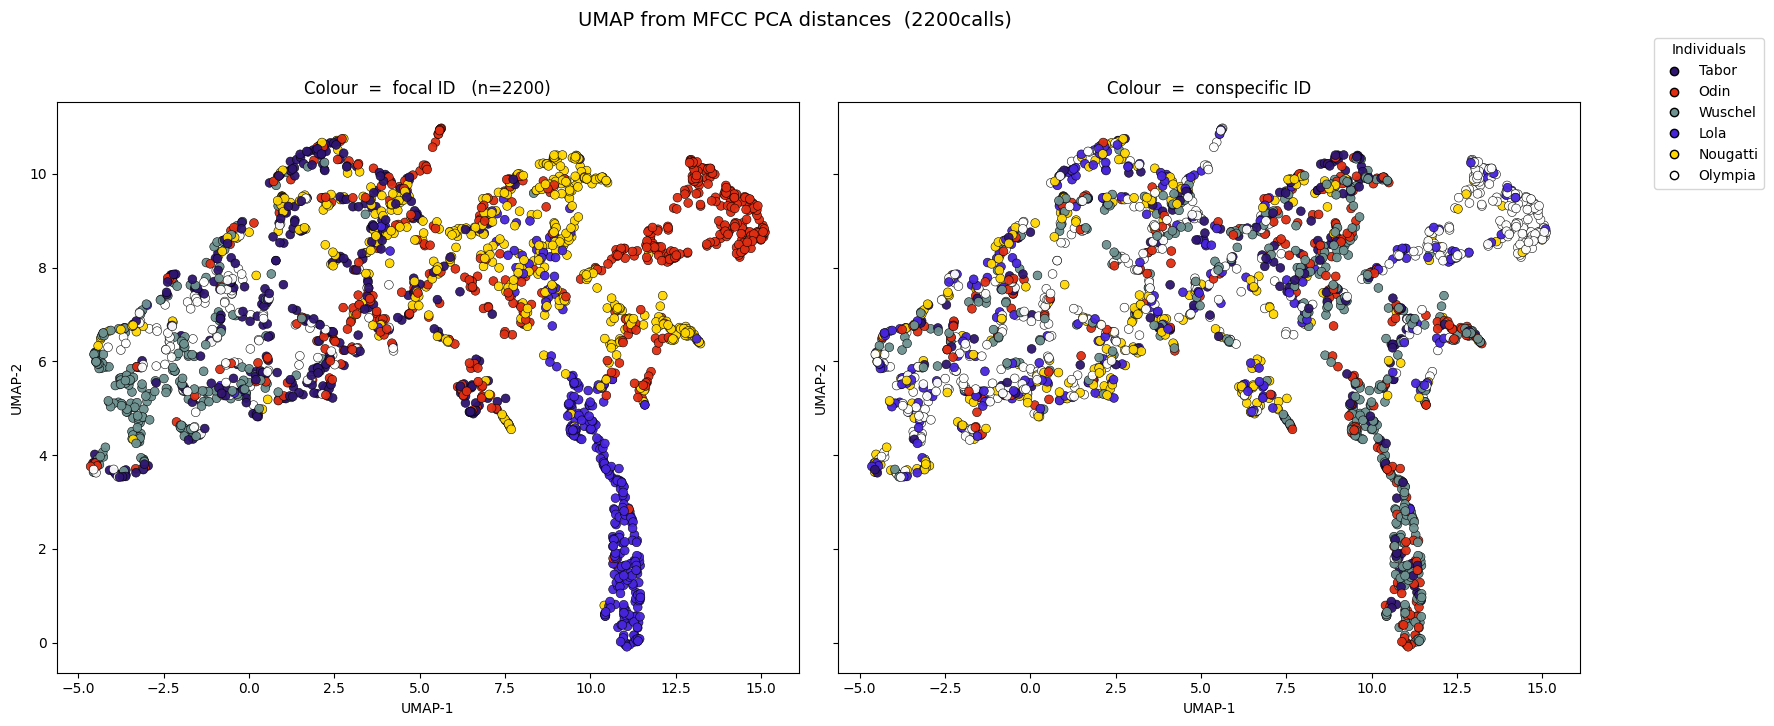

In [15]:
# %% ------------------------------------------------------------
#  UMAP  →  1×2 grid (colour by focal ID  vs  conspecific ID)
# ---------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, umap
from matplotlib.lines import Line2D
from pathlib import Path

# ── 0.  Pick which distance matrix to visualise ---------------- #
metric_key = "mfcc_pca"        # "dtw" | "trad_pca" | "mfcc_pca"
TAG        = "2200calls"   # matches filenames saved earlier

DIST_DIR   = BASE_DIR / "distance_matrices"
dist_mat   = np.load(DIST_DIR / f"{metric_key}_dist_matrix_{TAG}.npy")
sample_df  = pd.read_csv(DIST_DIR / f"labels_{TAG}.csv")

# ── 1.  UMAP embedding ---------------------------------------- #
coords = umap.UMAP(metric="precomputed", random_state=42).fit_transform(dist_mat)
sample_df["UMAP1"], sample_df["UMAP2"] = coords[:,0], coords[:,1]

# ── 2.  Colour palette ---------------------------------------- #
PALETTE = {
    "Tabor":"#2e1571","Odin":"#df2e12","Wuschel":"#6D9290",
    "Lola":"#4725DD","Nougatti":"#ffd700","Olympia":"#ffffff",
}

# ── 3.  Helper: scatter a panel -------------------------------- #
def plot_panel(ax, colour_by, title):
    ax.scatter(sample_df["UMAP1"], sample_df["UMAP2"],
               c=sample_df[colour_by].map(PALETTE),
               edgecolor='k', linewidth=0.4, s=40, alpha=0.95)
    ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
    ax.set_title(title)

# ── 4.  1×2 figure -------------------------------------------- #
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

plot_panel(axes[0], "focal ID",        f"Colour  =  focal ID   (n={len(sample_df)})")
plot_panel(axes[1], "conspecific_ID",  "Colour  =  conspecific ID")

# ── 5.  Legend (individual colours) --------------------------- #
handles = [Line2D([],[],marker='o',linestyle='',markeredgecolor='k',
                  markerfacecolor=col, label=name)
           for name,col in PALETTE.items()]
fig.legend(handles=handles, title="Individuals",
           loc="upper right", bbox_to_anchor=(1.11, 1.0))

plt.suptitle(f"UMAP from {metric_key.replace('_',' ').upper()} distances  ({TAG})",
             fontsize=14, y=1.03)
plt.tight_layout()
plt.show()



C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\nakul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\

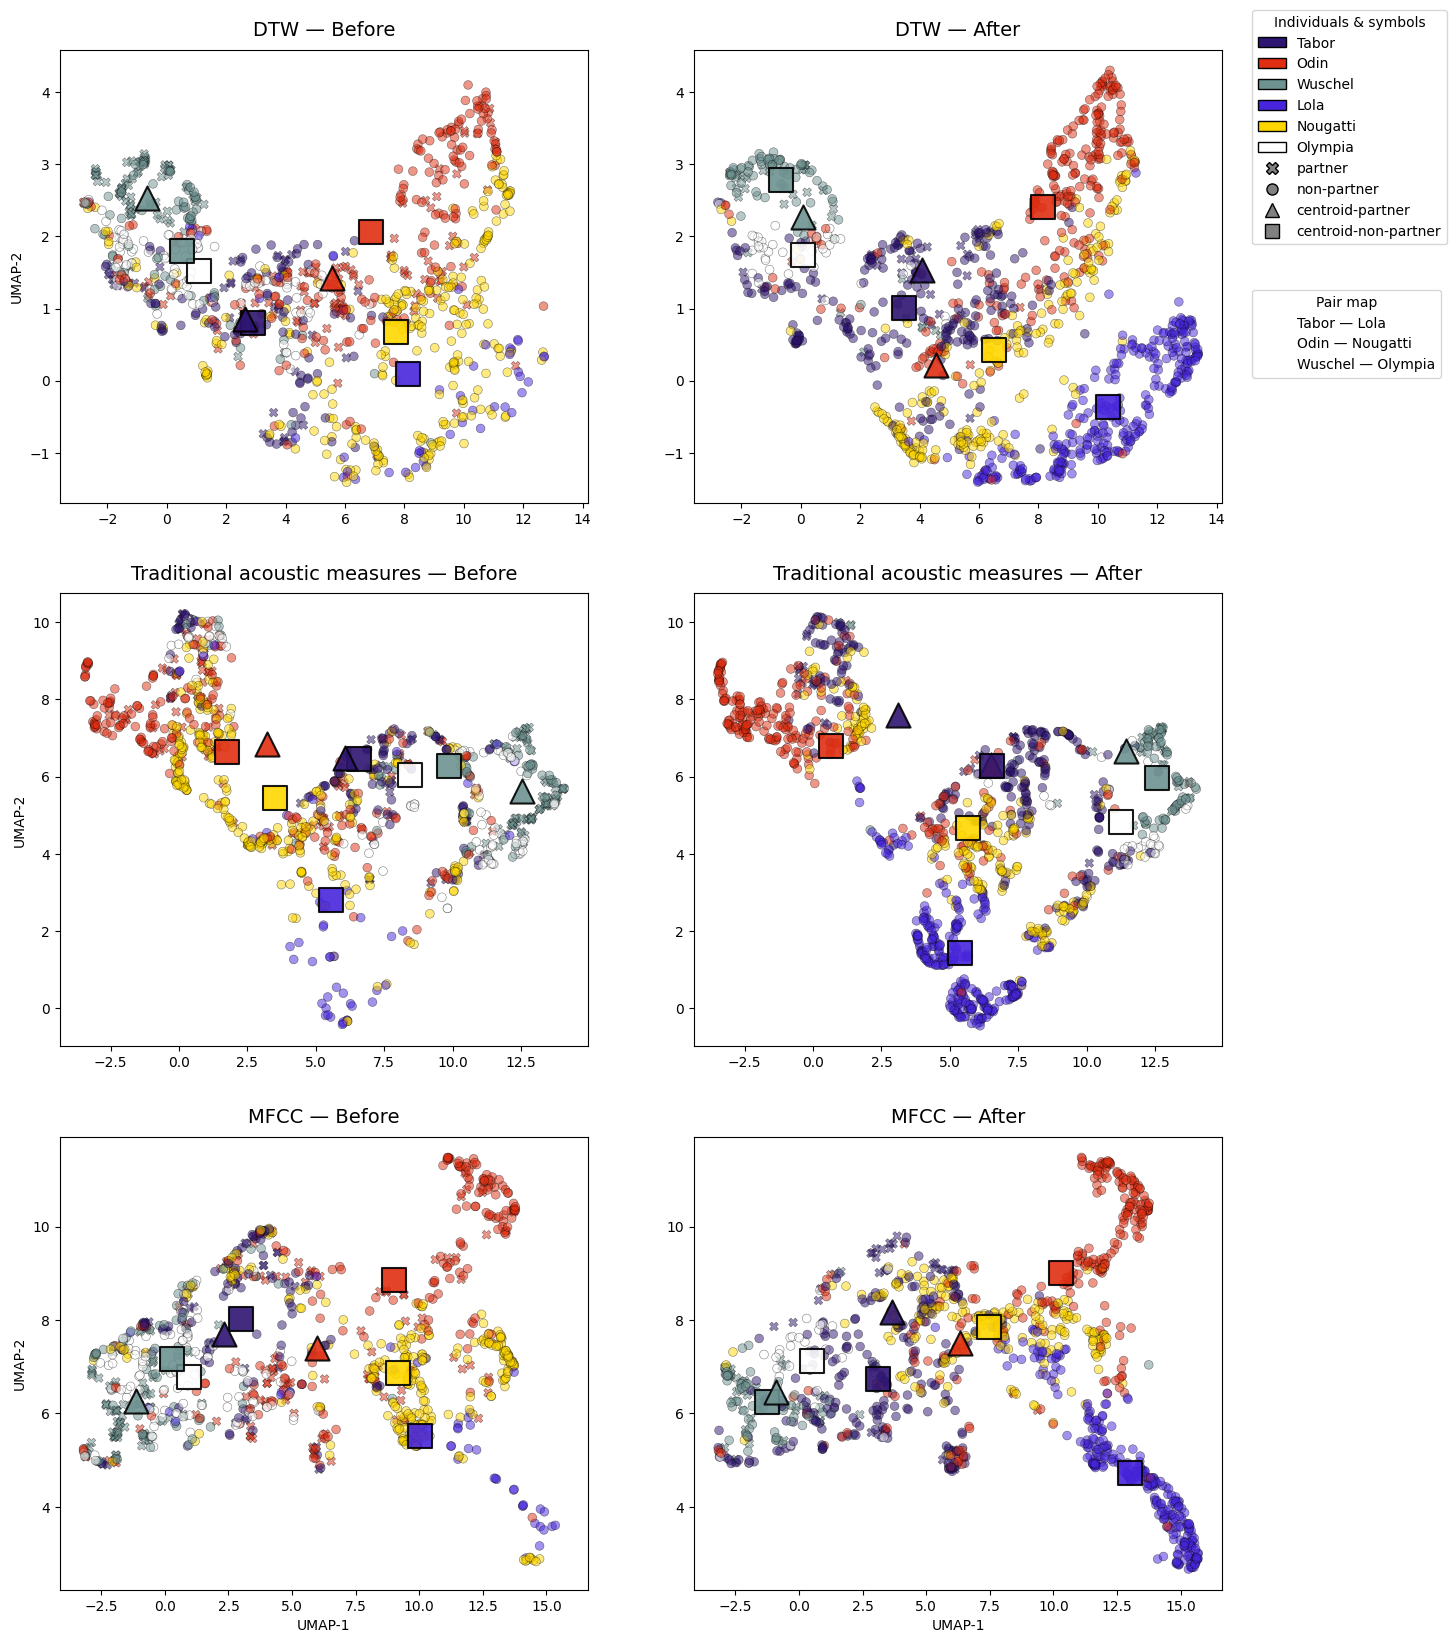

In [16]:
# %% ------------------------------------------------------------
#  UMAP grid (3 metrics × 2 stages)  +  transparent centroids
# ------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, umap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ── 0.  Load matrices & metadata -------------------------------- #
TAG      = "2200calls"               # adjust if needed
DIST_DIR = BASE_DIR / "distance_matrices"

dtw_mat   = np.load(DIST_DIR / f"dtw_dist_matrix_{TAG}.npy")
trad_mat  = np.load(DIST_DIR / f"trad_pca_dist_matrix_{TAG}.npy")
mfcc_mat  = np.load(DIST_DIR / f"mfcc_pca_dist_matrix_{TAG}.npy")
sample_df = pd.read_csv(DIST_DIR / f"labels_{TAG}.csv")

# ── 1.  Partner / non-partner flag ------------------------------ #
pair_map = {"Tabor":"Lola", 
            "Odin":"Nougatti", 
            "Wuschel":"Olympia"}
sample_df["partner_status"] = sample_df.apply(
    lambda r: "partner" if pair_map.get(r["focal ID"]) == r["conspecific_ID"]
              else "non-partner",
    axis=1,
)

# ── 2.  UMAP embeddings ---------------------------------------- #
def umap_embed(mat):
    return umap.UMAP(metric="precomputed",
                     n_neighbors=30, min_dist=0.1,
                     random_state=2).fit_transform(mat)

embeddings = {
    "DTW":      umap_embed(dtw_mat),
    "Traditional acoustic measures": umap_embed(trad_mat),
    "MFCC": umap_embed(mfcc_mat),
}
dfs = {m: sample_df.assign(UMAP1=e[:,0], UMAP2=e[:,1])
       for m, e in embeddings.items()}

# ── 3.  Plot constants ----------------------------------------- #
PALETTE = {"Tabor":"#2e1571",  "Odin":"#df2e12",  "Wuschel":"#6D9290",
           "Lola":"#4725DD",   "Nougatti":"#ffd700", "Olympia":"#ffffff"}

point_marker_map    = {"partner":"X", "non-partner":"o"}   # raw calls
centroid_marker_map = {"partner":"^", "non-partner":"s"}   # squares / diamonds

phases  = ["before", "after"]
metrics = ["DTW", "Traditional acoustic measures", "MFCC"]

# ── 4.  Draw 3×2 grid ------------------------------------------ #
fig, axs = plt.subplots(len(metrics), len(phases),
                        figsize=(15, 20), sharex=False, sharey=False)

for r, metric in enumerate(metrics):
    row_xlim, row_ylim = [], []
    for c, phase in enumerate(phases):
        ax  = axs[r, c]
        sub = dfs[metric][dfs[metric]["stage"] == phase]

        # ---- plot individual calls ------------------------------
        for status, marker in point_marker_map.items():
            pts = sub[sub["partner_status"] == status]
            ax.scatter(pts["UMAP1"], pts["UMAP2"],
                       c=pts["focal ID"].map(PALETTE),
                       marker=marker, edgecolor='k', linewidth=0.4,
                       s=40, alpha=0.5,
                       label=status if (r == 0 and c == 0) else None)

        # ---- overlay transparent centroids ----------------------
        centroids = (sub.groupby(["focal ID", "partner_status"])
                         [["UMAP1", "UMAP2"]].mean().reset_index())
        for _, row in centroids.iterrows():
            status   = row["partner_status"]
            marker_c = centroid_marker_map[status]
            ax.scatter(row["UMAP1"], row["UMAP2"],
                       marker=marker_c, s=300,
                       facecolor=PALETTE[row["focal ID"]],
                       edgecolor="black", linewidth=1.5,
                       alpha=0.9, zorder=5)

        # collect limits to sync within the metric row
        row_xlim.extend(ax.get_xlim())
        row_ylim.extend(ax.get_ylim())

        # ---- titles & axis labels -------------------------------
        ax.set_title(f"{metric} — {phase.capitalize()}",
                     pad=10, fontsize=14)
        if c == 0:
            ax.set_ylabel("UMAP-2")
        if r == len(metrics) - 1:
            ax.set_xlabel("UMAP-1")

    # apply same limits across each metric row
    xmin, xmax = min(row_xlim), max(row_xlim)
    ymin, ymax = min(row_ylim), max(row_ylim)
    for c in range(len(phases)):
        axs[r, c].set_xlim(xmin, xmax)
        axs[r, c].set_ylim(ymin, ymax)

# ── 5.  Unified legend (vertical, top‑right) ------------------- #
colour_handles = [Patch(facecolor=col, edgecolor='k', label=name)
                  for name, col in PALETTE.items()]

symbol_handles = [Line2D([], [], marker=m, linestyle='', markersize=8,
                         markeredgecolor='k', markerfacecolor='grey',
                         label=lab) for lab, m in point_marker_map.items()]

centroid_handles = [
    Line2D([], [], marker='^', linestyle='', markersize=10,
           markeredgecolor='k', markerfacecolor='grey',
           label='centroid‑partner'),
    Line2D([], [], marker='s', linestyle='', markersize=10,
           markeredgecolor='k', markerfacecolor='grey',
           label='centroid‑non‑partner')
]

legend_handles = colour_handles + symbol_handles + centroid_handles

fig.legend(handles=legend_handles,                 # <‑‑ key change
           title="Individuals & symbols",
           ncol=1, loc="upper left",
           bbox_to_anchor=(0.92, 0.90),
           borderaxespad=0.0)

# ── 5b. Pair‑map legend (immediately below the first) -----------
pair_handles = [
    Line2D([], [], marker='',
           linestyle='', label=f"{male} — {partner}")
    for male, partner in pair_map.items()
]
fig.legend(pair_handles, [h.get_label() for h in pair_handles],
           title="Pair map",
           ncol=1, loc="upper left",
           bbox_to_anchor=(0.92, 0.76),  # below the first legend
           borderaxespad=0.0)


